In [2]:
!pip install pandas

In [7]:
!pip install hyperopt

In [8]:
# There are a lot of warnings about CV not having enough data for each fold.
# TODO: Find a better way to deal with the warnings
import warnings
warnings.filterwarnings("ignore")

# Same old imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pylab as plt
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from tqdm import tqdm
import itertools

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# from tpot import TPOTClassifier



# Load the data and quick exploration

In [9]:
# Some constants
DATA_PATH = "Pokemon.csv"
TARGET_COL = "Type 1"
ENCODED_TARGET_COL = "encoded_type_1"
TO_DROP_COLS = ["#", "Name"]
# The dataset is small
TEST_RATIO = 0.1
# For reproducibility
SEED = 31415
RUN_HP_OPTIMIZATION = False
# Reduce this if needed! (resources are scarce here!)
MAX_EVALS = 200
HP_SPACE = {
    # Trying to reduce class imbalance
    'max_delta_step': 2, 
    # To avoid overfitting
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(1)), 
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(1)), 
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(1)),
}
# Optimal hp from previous run
OPTIMAL_HP = {'colsample_bytree': 0.7316836664311229, 'gamma': 0.04744535212276833, 
              'learning_rate': 0.02478735341127185, 'max_depth': 5.0, 'n_estimators': 349.0, 
              'reg_alpha': 0.03216806358838591, 'reg_lambda': 0.019055394071559602}
# Tpot conf values: increase these for more runs (and hopefully better results)
TPOT_GENERATION = 20
TPOT_POPULATION_SIZE = 100

In [10]:
# Some useful functions 


# Inspired from here: http://scikit-learn.org/stable/auto_examples/model_selection/
# plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True Type 1')
    ax.set_xlabel('Predicted Type 1')
    ax.grid(False)

In [11]:
pokemon_df = pd.read_csv(DATA_PATH)
pokemon_df.sample(5)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
749,680,Doublade,Steel,Ghost,448,59,110,150,45,49,35,6,False
291,268,Cascoon,Bug,NaN,205,50,35,55,25,25,15,3,False
426,384,RayquazaMega Rayquaza,Dragon,Flying,780,105,180,100,180,100,115,3,True
730,662,Fletchinder,Fire,Flying,382,62,73,55,56,52,84,6,False
593,533,Gurdurr,Fighting,NaN,405,85,105,85,40,50,40,5,False


Notice that the `#` and `Name` columns aren't useful for predicting the major type so will be dropped (these are the `TO_DROP_COLS`).  

In [ ]:
pokemon_df.dtypes

As mentionned in the beginning, I will predict the major type (this is the `Type 1` column). 
Let's explore the target to start. 

Text(0.5, 0, "Pokemons' Type 1")

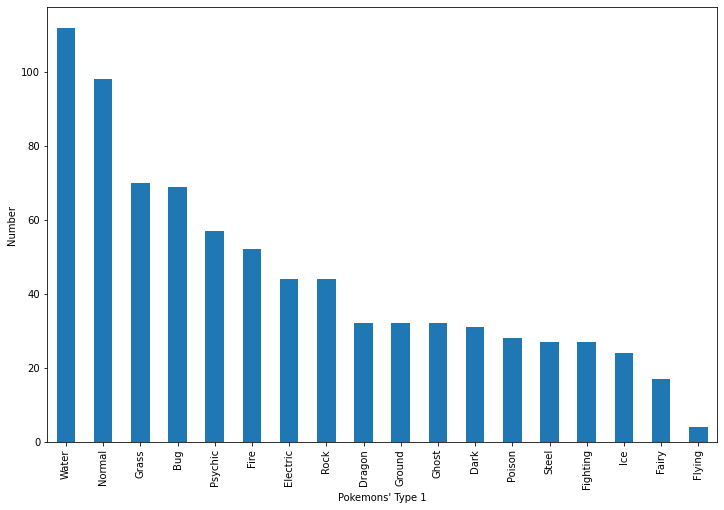

In [12]:
target_s = pokemon_df['Type 1']
"There are {} unique major types".format(target_s.nunique())
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
target_s.value_counts().plot(kind='bar', ax=ax)
ax.set_ylabel('Number')
ax.set_xlabel("Pokemons' Type 1")

Text(0.5, 0, "Pokemons' Type 1")

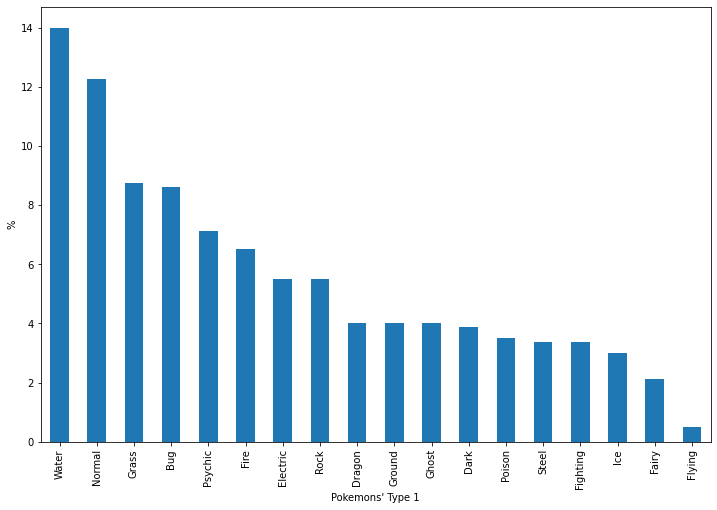

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
target_s.value_counts(normalize=True).mul(100).plot(kind='bar', ax=ax)
ax.set_ylabel('%')
ax.set_xlabel("Pokemons' Type 1")

Based on the target's historgrams: 

1. This is a **multi-class** (**18** major types) **classification** (categorical target) problem
2. This is an **unblanaced** problem. Indeed, some types (fairy and flying) are much less common than the other ones.

Notice that some major types (check the EDA notebook) aren't present for all the generations: flying, dark, and steel types aren't available for the six generations. 

Thus some **features engineering** based on the `Generation` column might be useful. 

Let's **dummify** (i.e. transform categorical columns into boolean ones) the target, the `Type 2` and `Generation` columns. 

For that I use pandas [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) function. Also, since not every Pokemon has a `Type 2`, I have filled the missing values with the "missing" type before dummifying. Notice also that I have used a `LabelEncoder` for the target col (since the target contains strings). 

Finally, I drop the `TARGET_COL` and `TO_DROP_COLS` (i.e. `Name` and `#`) columns from the features. 

In [14]:
le = LabelEncoder()
encoded_target_s = pd.Series(le.fit_transform(target_s), name=ENCODED_TARGET_COL)
dummified_target_s = pd.get_dummies(target_s)
dummified_features_df = (pokemon_df.drop(TO_DROP_COLS + [TARGET_COL], axis=1)
                                   .assign(Generation=lambda df: df.Generation.astype(str))
                                   .assign(**{"Legendary": lambda df: df["Legendary"].astype(int), 
                                              "Type 2": lambda df: df["Type 2"].fillna("missing")})
                                   .pipe(pd.get_dummies))
features_and_targets_df = pd.concat([encoded_target_s, dummified_features_df], axis=1)

In [15]:
encoded_target_s.sample(5)

143    12
97     17
483    13
667    14
394    14
Name: encoded_type_1, dtype: int32

In [16]:
le.inverse_transform(encoded_target_s.sample(5))

array(['Water', 'Dark', 'Electric', 'Water', 'Fire'], dtype=object)

In [17]:
dummified_target_s.sample(5)

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
751,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
690,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
235,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [18]:
dummified_features_df.sample(5)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 2_Bug,Type 2_Dark,...,Type 2_Rock,Type 2_Steel,Type 2_Water,Type 2_missing,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6
337,295,40,45,40,65,40,65,0,0,0,...,0,0,0,1,0,0,1,0,0,0
267,600,100,134,110,95,100,61,0,0,1,...,0,0,0,0,0,1,0,0,0,0
552,720,120,120,120,120,120,120,1,0,0,...,0,0,0,1,0,0,0,1,0,0
193,280,55,40,40,65,45,35,0,0,0,...,0,0,0,1,0,1,0,0,0,0
643,305,36,50,50,65,60,44,0,0,0,...,0,0,0,1,0,0,0,0,1,0


To end this preparation phase, let's see if there are any **correlations**

<AxesSubplot:>

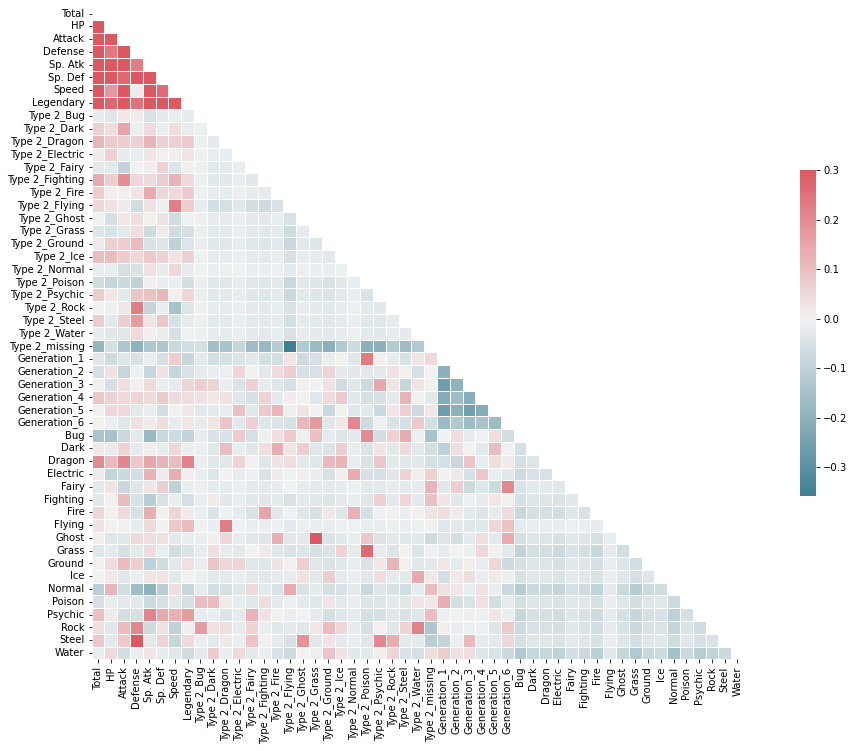

In [19]:
# Inspired from this: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr_df = pd.concat([dummified_features_df, dummified_target_s], axis=1).corr()


mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



Some correlations: 

* **Steel** major types tend to be positivelt correlated with **Defense** and **Psychic** with ** Special Attack**. 
* **Ghost** major types tend to be positvely correlated with a Type 2 of **Grass** and **Grass** with **Poison**. 
* **Fairy** major types tend to be positvely correlated with the **Generation** 6. 
* **Dragon** major types tend to be positvely correlated with **Attack** and **Total**. 

These observations aren't surprising to any true Pokemon connoisseur but are, nonethless, reassuring to find using the data. 

## Train and test split

I will split the features and targets into train and test datasets. 

The test dataset will only be used at the end to evaluate the various trained models (you should do this as well whenever you train an ML model). Next, I will use cross validation to train and evaluate the model using the train dataset. 

In [20]:
train_df, test_df = train_test_split(features_and_targets_df, 
                                     stratify=encoded_target_s, 
                                     test_size=TEST_RATIO, random_state=SEED)

In [21]:
train_df.head(1).T

,526
encoded_type_1,14
Total,518
HP,68
Attack,125
Defense,65
Sp. Atk,65
Sp. Def,115
Speed,80
Legendary,0
Type 2_Bug,0


# Evaluation metric

Alright, now that the features have been prepared and split, it is time to pick an evaluation metric. 

Since this an **nbalanced multi-class classification** problem, I will be using the [**F1 score**](https://en.wikipedia.org/wiki/F1_score) with **weighted** average: the F1 score is computed for each class then we take the weighted average using the true classes count.

Check the sklearn documentation for more details [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). In what follows, I have provied two examples of usage of the `f1_score`(unblanaced and balanced classes). 

In [22]:
# The three variations of the F1 score for unbalanced classes are different for unblanaced classes

true_classes = ["a", "b", "c", "a", "c", "c"]
predicted_classes = ["a", "b", "c", "c", "c", "c"]

print("Unbalanced: ")
print("Weighted F1 score:", f1_score(true_classes, predicted_classes, average="weighted"))
print("Micro F1 score:", f1_score(true_classes, predicted_classes, average="micro"))
print("Macro F1 score:", f1_score(true_classes, predicted_classes, average="macro"))

# The three variations of the F1 score for balanced classes are the same

true_classes = ["a", "b", "c", "a", "b", "c"]
predicted_classes = ["a", "b", "c", "a", "b", "c"]
print(32 * "-")

print("Balanaced: ")
print("Weighted F1 score:", f1_score(true_classes, predicted_classes, average="weighted"))
print("Micro F1 score:", f1_score(true_classes, predicted_classes, average="micro"))
print("Macro F1 score:", f1_score(true_classes, predicted_classes, average="macro"))

Unbalanced: 
Weighted F1 score: 0.8174603174603173
Micro F1 score: 0.8333333333333334
Macro F1 score: 0.8412698412698413
--------------------------------
Balanaced: 
Weighted F1 score: 1.0
Micro F1 score: 1.0
Macro F1 score: 1.0


# Baseline model

As with any ML problem, one usually starts by establishing a baseline, i.e. a score/error that one aims at improving. 
Why is that important? Well, without a baseline, it is hard to tell if one is making progress or not. Moreover, some problems are much easier than others: a very high accuracy might look impressive
but is less impressive one compared to a high accuracy obtained with a very simple model. 

As a baseline, let's use a linear regression model.


In [23]:
train_features_df = train_df.drop(ENCODED_TARGET_COL, axis=1)
train_target_s = train_df[ENCODED_TARGET_COL]

In [24]:
def improvement_in_percent(model_score, baseline_score):
    return (100 * (model_score - baseline_score)  / baseline_score).round(3)

In [25]:
lr = LogisticRegression(random_state=SEED)
lr_scores = cross_val_score(lr, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Logistic regression mean and std scores are: ({}, {})".format(lr_scores.mean(), lr_scores.std()))
lr.fit(train_features_df, train_target_s)

Logistic regression mean and std scores are: (0.17909271515519115, 0.02517962720790275)


LogisticRegression(random_state=31415)

# Simple XGBoost

Now that a baseline score has been found, let's try to improve it. 

In [26]:
xgb_clf = XGBClassifier(random_state=SEED)
xgb_clf_scores = cross_val_score(xgb_clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
"Simple XGBoost classification mean and std scores are: ({}, {})".format(xgb_clf_scores.mean(), xgb_clf_scores.std())

'Simple XGBoost classification mean and std scores are: (0.242854518683232, 0.028714908121174096)'

A "simple" (no hyperparameters tuning) XGBoost classifier does better than the baseline. 

In [27]:
"This is a {} % improvement".format(improvement_in_percent(xgb_clf_scores.mean(), lr_scores.mean()))

'This is a 35.603 % improvement'

Could we do better?

Let's try to vary the hyperparamters for the XGBoost classifier and see what we get.

In [28]:
# More trees
clf = XGBClassifier(random_state=SEED, n_estimators=1000)
clf_scores = cross_val_score(clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Alternative XGBoost classification mean and std scores are: ({}, {})".format(clf_scores.mean(), clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(clf_scores.mean(), lr_scores.mean())))

Alternative XGBoost classification mean and std scores are: (0.2340842609055321, 0.04125895710346093)
This is a 30.706 % improvement


In [29]:
# Smaller learning rate
clf = XGBClassifier(random_state=SEED, learning_rate=0.01)
clf_scores = cross_val_score(clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Alternative XGBoost classification mean and std scores are: ({}, {})".format(clf_scores.mean(), clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(clf_scores.mean(), lr_scores.mean())))

Alternative XGBoost classification mean and std scores are: (0.2486615914791838, 0.03695407358332735)
This is a 38.845 % improvement


In [30]:
class HPOptimizer(object):

    def __init__(self):
        # A progress bar to monitor the hyperopt optimization process
        self.pbar = tqdm(total=MAX_EVALS, desc="Hyperopt")
        self.trials = Trials()

    def objective(self, hyperparameters):
        hyperparameters = {
            "max_delta_step": hyperparameters["max_delta_step"],
            "reg_alpha": '{:.3f}'.format(hyperparameters["reg_alpha"]), 
            "reg_lambda": '{:.3f}'.format(hyperparameters["reg_lambda"]), 
            "n_estimators": int(hyperparameters["n_estimators"]), 
            "max_depth": int(hyperparameters["max_depth"]),
            "learning_rate": '{:.3f}'.format(hyperparameters["learning_rate"]), 
            "colsample_bytree": '{:.3f}'.format(hyperparameters['colsample_bytree']),
            "gamma": "{:.3f}".format(hyperparameters['gamma']),
        }
        print("The current hyperparamters are: {}".format(hyperparameters))

        clf = XGBClassifier(
            n_jobs=4,
            **hyperparameters
        )

        scores = cross_val_score(clf, X=train_features_df, y=train_target_s, cv=5, 
                                 scoring="f1_weighted")
        print("Mean and std CV scores are: ({}, {})".format(scores.mean(), scores.std()))
        # Update the progress bar after each iteration
        self.pbar.update()
        # Since we are minimizing the objective => return -1 * mean(scores) (this is a loss)
        return -scores.mean()

    def run(self):
        if RUN_HP_OPTIMIZATION:
            optimal_hp = fmin(fn=objective,
                              space=HP_SPACE,
                              algo=tpe.suggest,
                              trials= trials,
                              max_evals=MAX_EVALS)
        else:
            optimal_hp = OPTIMAL_HP
        self.optimal_hp = optimal_hp

In [31]:
hp_optimizer = HPOptimizer()
hp_optimizer.run()
optimal_hp = hp_optimizer.optimal_hp
print("The optimal hyperparamters are: {}".format(optimal_hp))

Hyperopt:   0%|          | 0/200 [00:00<?, ?it/s]

The optimal hyperparamters are: {'colsample_bytree': 0.7316836664311229, 'gamma': 0.04744535212276833, 'learning_rate': 0.02478735341127185, 'max_depth': 5.0, 'n_estimators': 349.0, 'reg_alpha': 0.03216806358838591, 'reg_lambda': 0.019055394071559602}


Let's explore the saved trials (these are handy to store hyperopt runs).

In [32]:
if RUN_HP_OPTIMIZATION:
    hyperaramters_df = pd.DataFrame(trials.idxs_vals[1])
    losses_df = pd.DataFrame(trials.results)
    hyperopt_trials_df = pd.concat([losses_df, hyperaramters_df], axis=1)

In [33]:
if RUN_HP_OPTIMIZATION:
    # Check that the argmin of the hyperopt_trials_df DataFrame is the same as the optimal_hp 
    min_loss_index = losses_df['loss'].argmin()
    assert (hyperaramters_df.loc[min_loss_index, :].to_dict() == optimal_hp)

In [34]:
def hp_vs_loss_scatterplot(hyperparameter):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    hyperopt_trials_df.plot(x=hyperparameter, y='loss', kind='scatter', ax=ax)
    best_coordinates = hyperopt_trials_df.loc[min_loss_index, [hyperparameter, "loss"]].values
    ax.annotate("Best {}: {}".format(hyperparameter, round(best_coordinates[0], 3)), 
                xy=best_coordinates, 
                color="red")

In [35]:
if RUN_HP_OPTIMIZATION:
    # Remove the "max_delta_step" since it is fixed for now
    HP_SPACE.pop("max_delta_step")
    for hyperparmeter in HP_SPACE.keys():
        hp_vs_loss_scatterplot(hyperparmeter)

Let's train our best XGBoost classifier (using the optimal hyperparamters) on the train dataet then evaluate it on the test dataset.

In [36]:
parsed_optimal_hp = {
    "n_estimators": int(optimal_hp["n_estimators"]), 
    "max_depth": int(optimal_hp["max_depth"]),
    "learning_rate": optimal_hp["learning_rate"], 
    "colsample_bytree": '{:.3f}'.format(optimal_hp['colsample_bytree']),
    "gamma": "{:.3f}".format(optimal_hp['gamma']),
}

best_xgb_clf =  XGBClassifier(random_state=SEED, **parsed_optimal_hp)
best_xgb_clf.fit(train_features_df, train_target_s)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree='0.732',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma='0.047', gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02478735341127185,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=349,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

# Random Forests

Let's try other models starting with a random forests classifier

In [37]:
rf_clf = RandomForestClassifier(random_state=SEED)
rf_clf_scores = cross_val_score(rf_clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Simple random forests classification mean and std scores are: ({}, {})".format(rf_clf_scores.mean(), rf_clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(rf_clf_scores.mean(), lr_scores.mean())))

Simple random forests classification mean and std scores are: (0.26614013332069697, 0.022754247384498154)
This is a 48.605 % improvement
